In [1]:
# ============================================================================
# CONFIGURATION DU NOTEBOOK
# ============================================================================

import datetime


"""Configuration MLflow"""
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"
MLFLOW_EXPERIMENT_NAME = "OC_P6_Credit_Scoring"

# Configuration du projet
PROJECT_VERSION = "1.0"
MODEL_NAME = "LightGBM"
NOTEBOOK_NAME = "03_LGBM"
RUN_DATE = datetime.datetime.now()

# Configuration des données
DATA_PATH = "../data/processed/"
TRAIN_FILE = "features_train.csv"
TEST_FILE = "features_test.csv"

# Configuration du modèle baseline
MODEL_CONFIG = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "num_leaves": 31,
    "class_weight": "balanced",
    "random_state": 42
}

# Configuration de la validation
VALIDATION_SPLIT_RATIO = 0.2
RANDOM_STATE = 42

# Configuration des tags MLflow
MLFLOW_TAGS = {
    "project_version": PROJECT_VERSION,
    "notebook": NOTEBOOK_NAME,
    "phase": "baseline",
    "desequilibre_handling": "class_weight_balanced",
    "date": RUN_DATE,
}

# Dictionnaire standard des métriques (schéma unique pour tous les runs)
STANDARD_METRICS = {
    "auc": float,              # AUC-ROC
    "business_cost_min": float, # Coût métier minimal (10*FN + FP)
    "optimal_threshold": float, # Seuil qui minimise le coût métier
    "f1_score": float,         # F1 au seuil optimal
    "recall_class1": float,    # Recall classe minoritaire au seuil optimal
}

# Valeur par défaut si une métrique n'est pas calculable pour un run donné
DEFAULT_METRIC_VALUE = -1.0

print("Configuration chargée avec succès !")
print(f"MLflow Experiment: {MLFLOW_EXPERIMENT_NAME}")
print(f"Project Version: {PROJECT_VERSION}")
print(f"Model: {MODEL_NAME}")

Configuration chargée avec succès !
MLflow Experiment: OC_P6_Credit_Scoring
Project Version: 1.0
Model: LightGBM


# 03 - LightGBM Modeling with MLflow Tracking

Configuration and experimentation notebook for credit scoring model.
All runs will be tracked in MLflow for comparison and reproducibility.

In [2]:
from src.mlflow_config import configure_mlflow

mlflow = configure_mlflow(autolog=False)

In [3]:
# ============================================================================
# CLEANUP & VERIFICATION (Optionnel mais recommandé)
# ============================================================================
from mlflow.tracking import MlflowClient

client = MlflowClient(MLFLOW_TRACKING_URI)

# Récupérer l'expérience
experiment = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
experiment_id = experiment.experiment_id if experiment else "0"

print("📊 État MLflow au démarrage:")
print(f"   Expérience: {MLFLOW_EXPERIMENT_NAME} (ID: {experiment_id})")

# Récupérer les runs actuels
runs = client.search_runs(experiment_ids=[experiment_id])
print(f"   Nombre de runs existants: {len(runs)}")

# Liste des runs attendus (clean)
EXPECTED_RUN_NAMES = {
    "LGBM_baseline_CV",
    "LGBM_optuna_tuning",
    "best_params_cv_evaluation",  # enfant
    "final_model",                 # enfant
    "LGBM_final_validation",
    "LGBM_final_interpretability",
    "LightGBM_baseline_1.0"
}

# Détecter les runs parasites
actual_run_names = {run.data.tags.get("mlflow.runName", "unknown") for run in runs}
parasite_runs = actual_run_names - EXPECTED_RUN_NAMES

if parasite_runs:
    print(f"\n⚠️  Runs parasites détectés: {parasite_runs}")
    print("   Pour les supprimer, dé-commenter les lignes ci-dessous:")
    print("   # for run in runs:")
    print("   #     if run.data.tags.get('mlflow.runName') in parasite_runs:")
    print("   #         client.delete_run(run.info.run_id)")
else:
    print("\n✅ Aucun run parasite détecté")

📊 État MLflow au démarrage:
   Expérience: OC_P6_Credit_Scoring (ID: 1)
   Nombre de runs existants: 0

✅ Aucun run parasite détecté


In [4]:
import pandas as pd

# Exemple si tu as sauvegardé les features
X_train = pd.read_csv("../data/processed/features_train.csv")
y_train = X_train.pop("TARGET")  # ou le nom de ta cible
# Même chose pour X_val, y_val si tu as un split

In [5]:
# ============================================================================
# Cross-validation LightGBM + coût métier
# ============================================================================
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, recall_score
import warnings

# Désactiver le warning MLflow pip
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')

# Nettoyage des colonnes avant entraînement (noms + types)
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    for col in object_cols:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
X_train.columns = (
    X_train.columns
    .str.replace(' ', '_')
    .str.replace('[^a-zA-Z0-9_]', '_', regex=True)
    .str.replace('__+', '_', regex=True)
 )

# Paramètres modèle (assurer class_weight=balanced)
MODEL_CONFIG_CV = {**MODEL_CONFIG, "class_weight": "balanced"}

# K-Fold stratifié
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_results = []
thresholds = np.round(np.arange(0.1, 0.91, 0.05), 2)

RUN_NAME_CV = "LGBM_baseline_CV"

# Logging uniformisé pour comparaison facile
with mlflow.start_run(run_name=RUN_NAME_CV):
    # Log paramètres
    mlflow.log_params(MODEL_CONFIG_CV)
    
    # Log tags existants
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("phase", "baseline_cv")
    mlflow.set_tag("evaluation_type", "cv_stratified")
    mlflow.set_tag("threshold_optimized", "yes")
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LGBMClassifier(**MODEL_CONFIG_CV)
        model.fit(X_tr, y_tr)
        
        y_val_proba = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_proba)
        
        best_threshold = None
        min_cost = None
        best_fp = None
        best_fn = None
        
        for thr in thresholds:
            y_val_pred = (y_val_proba >= thr).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
            cost = 10 * fn + 1 * fp
            if (min_cost is None) or (cost < min_cost):
                min_cost = cost
                best_threshold = thr
                best_fp = fp
                best_fn = fn
        
        # F1 et Recall au seuil optimal du fold
        y_val_pred_opt = (y_val_proba >= best_threshold).astype(int)
        f1_fold = f1_score(y_val, y_val_pred_opt)
        recall_fold = recall_score(y_val, y_val_pred_opt)
        
        fold_results.append({
            "fold": fold_idx,
            "auc": auc,
            "best_threshold": best_threshold,
            "min_cost": min_cost,
            "fp": best_fp,
            "fn": best_fn,
            "f1_score": f1_fold,
            "recall_class1": recall_fold
        })
    
    cv_results_df = pd.DataFrame(fold_results)
    cv_auc_mean = cv_results_df["auc"].mean()
    cv_min_cost_mean = cv_results_df["min_cost"].mean()
    cv_best_threshold_mean = cv_results_df["best_threshold"].mean()
    cv_f1_mean = cv_results_df["f1_score"].mean()
    cv_recall_mean = cv_results_df["recall_class1"].mean()
    
    # Log métriques standardisées
    mlflow.log_metric("auc", cv_auc_mean)
    mlflow.log_metric("business_cost_min", cv_min_cost_mean)
    mlflow.log_metric("optimal_threshold", cv_best_threshold_mean)
    mlflow.log_metric("f1_score", cv_f1_mean)
    mlflow.log_metric("recall_class1", cv_recall_mean)
    
    # Log artefact JSON
    mlflow.log_dict(cv_results_df.to_dict(orient="records"), "cv_results.json")
    
    print("✓ Cross-validation terminée")
    print(f"AUC moyen: {cv_auc_mean:.4f}")
    print(f"Coût métier moyen: {cv_min_cost_mean:.2f}")
    print(f"Seuil optimal moyen: {cv_best_threshold_mean:.2f}")

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19266
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 644
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19578
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 646
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM

In [6]:
# ============================================================================
# Optimisation RAPIDE Optuna (~10 min max)
# ============================================================================
import numpy as np
import optuna
from optuna.pruners import MedianPruner
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, recall_score
import warnings

# Désactiver le warning MLflow pip
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')

print("\n" + "="*70)
print("🔧 OPTUNA OPTIMIZATION - Fast iteration")
print("="*70)

# Seuils grossiers pour vitesse (6 valeurs)
thresholds_optuna = np.arange(0.2, 0.8, 0.1)

# CV accélérée : 3 folds
skf_optuna = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ==========================================================================
# FONCTION UTILITAIRE : Calcul du coût métier minimal par fold
# ==========================================================================
def compute_min_cost_per_fold(y_true, y_proba, thresholds_array):
    """
    Trouve le seuil optimal qui minimise le coût métier.
    Coût = 10 * FN + 1 * FP
    """
    min_cost = float('inf')
    best_threshold = 0.5
    
    for thr in thresholds_array:
        y_pred = (y_proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = 10 * fn + 1 * fp
        
        if cost < min_cost:
            min_cost = cost
            best_threshold = thr
    
    return min_cost, best_threshold

# ==========================================================================
# OBJECTIVE OPTUNA
# ==========================================================================
def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 31, 128),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.1, log=True),
        "n_estimators": 500,
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 80),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "class_weight": "balanced",
        "random_state": 42,
        "verbose": -1,
    }
    
    fold_costs = []
    for train_idx, val_idx in skf_optuna.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        
        y_val_proba = model.predict_proba(X_val)[:, 1]
        min_cost, _ = compute_min_cost_per_fold(y_val, y_val_proba, thresholds_optuna)
        fold_costs.append(min_cost)
        
        trial.report(np.mean(fold_costs), step=len(fold_costs)-1)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return -np.mean(fold_costs)

# ==========================================================================
# LANCEMENT OPTUNA DANS UN RUN PARENT
# ==========================================================================
print("\n🚀 Lancement Optuna: 15 trials, 3-fold CV, timeout=600s...")

# Logging uniformisé pour comparaison facile
with mlflow.start_run(run_name="LGBM_optuna_tuning") as parent_run:
    # Tags du run parent
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("phase", "optuna_tuning")
    mlflow.set_tag("evaluation_type", "cv_stratified")
    mlflow.set_tag("threshold_optimized", "yes")
    
    # Optuna optimization
    pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=15, timeout=600, show_progress_bar=True)
    
    # Récupérer best_params
    best_params = study.best_params.copy()
    best_params["class_weight"] = "balanced"
    best_params["random_state"] = 42
    best_params["n_estimators"] = 500
    best_params["verbose"] = -1
    
    print(f"\n✓ Optuna terminé: {len(study.trials)} trials")
    print(f"Best params: {best_params}")
    print(f"Best score (negative cost): {study.best_value:.2f}")
    
    # Log des paramètres Optuna
    mlflow.log_params(best_params)
    mlflow.log_metric("optuna_best_score", study.best_value)
    mlflow.log_metric("optuna_n_trials", len(study.trials))
    
    # ==========================================================================
    # RE-ÉVALUATION EN CV AVEC LES MEILLEURS PARAMÈTRES (nested run)
    # ==========================================================================
    print("\n📊 Évaluation finale en CV avec best_params...")
    
    # Logging uniformisé pour comparaison facile
    with mlflow.start_run(run_name="best_params_cv_evaluation", nested=True):
        # Tags du run nested
        for tag_key, tag_value in MLFLOW_TAGS.items():
            mlflow.set_tag(tag_key, tag_value)
        mlflow.set_tag("model_type", MODEL_NAME)
        mlflow.set_tag("phase", "best_params_cv")
        mlflow.set_tag("evaluation_type", "cv_stratified")
        mlflow.set_tag("threshold_optimized", "yes")
        
        best_fold_results = []
        for fold_idx, (train_idx, val_idx) in enumerate(skf_optuna.split(X_train, y_train), start=1):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model = LGBMClassifier(**best_params)
            model.fit(X_tr, y_tr)
            
            y_val_proba = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_val_proba)
            min_cost, best_thr = compute_min_cost_per_fold(y_val, y_val_proba, thresholds_optuna)
            
            # F1 et Recall au seuil optimal du fold
            y_val_pred_opt = (y_val_proba >= best_thr).astype(int)
            f1_fold = f1_score(y_val, y_val_pred_opt)
            recall_fold = recall_score(y_val, y_val_pred_opt)
            
            best_fold_results.append({
                "fold": fold_idx,
                "auc": auc,
                "best_threshold": best_thr,
                "min_cost": min_cost,
                "f1_score": f1_fold,
                "recall_class1": recall_fold
            })
        
        best_cv_df = pd.DataFrame(best_fold_results)
        best_cv_auc_mean = best_cv_df["auc"].mean()
        best_cv_min_cost_mean = best_cv_df["min_cost"].mean()
        best_cv_best_threshold_mean = best_cv_df["best_threshold"].mean()
        best_cv_f1_mean = best_cv_df["f1_score"].mean()
        best_cv_recall_mean = best_cv_df["recall_class1"].mean()
        
        # Log métriques standardisées
        mlflow.log_metric("auc", best_cv_auc_mean)
        mlflow.log_metric("business_cost_min", best_cv_min_cost_mean)
        mlflow.log_metric("optimal_threshold", best_cv_best_threshold_mean)
        mlflow.log_metric("f1_score", best_cv_f1_mean)
        mlflow.log_metric("recall_class1", best_cv_recall_mean)
        mlflow.log_dict(best_cv_df.to_dict(orient="records"), "cv_results.json")
        
        print(f"\n✓ Résultats CV (best_params):")
        print(f"  AUC moyen: {best_cv_auc_mean:.4f}")
        print(f"  Coût métier moyen: {best_cv_min_cost_mean:.2f}")
        print(f"  Seuil optimal moyen: {best_cv_best_threshold_mean:.2f}")
    
    # Logging uniformisé pour comparaison facile (métriques du meilleur CV)
    if "best_cv_auc_mean" in locals():
        mlflow.log_metric("auc", best_cv_auc_mean)
        mlflow.log_metric("business_cost_min", best_cv_min_cost_mean)
        mlflow.log_metric("optimal_threshold", best_cv_best_threshold_mean)
        mlflow.log_metric("f1_score", best_cv_f1_mean)
        mlflow.log_metric("recall_class1", best_cv_recall_mean)
    else:
        # CV non disponible => valeurs par défaut pour garder l'uniformité
        mlflow.log_metric("auc", DEFAULT_METRIC_VALUE)
        mlflow.log_metric("business_cost_min", DEFAULT_METRIC_VALUE)
        mlflow.log_metric("optimal_threshold", DEFAULT_METRIC_VALUE)
        mlflow.log_metric("f1_score", DEFAULT_METRIC_VALUE)
        mlflow.log_metric("recall_class1", DEFAULT_METRIC_VALUE)
    
    # ==========================================================================
    # MODÈLE FINAL (nested run)
    # ==========================================================================
    # Logging uniformisé pour comparaison facile
    with mlflow.start_run(run_name="final_model", nested=True):
        mlflow.log_params(best_params)
        
        # Tags du run nested
        for tag_key, tag_value in MLFLOW_TAGS.items():
            mlflow.set_tag(tag_key, tag_value)
        mlflow.set_tag("model_type", MODEL_NAME)
        mlflow.set_tag("phase", "final_model")
        mlflow.set_tag("evaluation_type", "train_full")
        mlflow.set_tag("threshold_optimized", "no")
        
        # Pas d'évaluation dans ce run => métriques par défaut pour uniformité
        mlflow.log_metric("auc", DEFAULT_METRIC_VALUE)
        mlflow.log_metric("business_cost_min", DEFAULT_METRIC_VALUE)
        mlflow.log_metric("optimal_threshold", DEFAULT_METRIC_VALUE)
        mlflow.log_metric("f1_score", DEFAULT_METRIC_VALUE)
        mlflow.log_metric("recall_class1", DEFAULT_METRIC_VALUE)
        
        final_model = LGBMClassifier(**best_params)
        final_model.fit(X_train, y_train)
        
        mlflow.lightgbm.log_model(final_model, name=MODEL_NAME)
        
        print("\n✅ Run MLflow 'LGBM_optuna_tuning' terminé avec nested runs")


🔧 OPTUNA OPTIMIZATION - Fast iteration

🚀 Lancement Optuna: 15 trials, 3-fold CV, timeout=600s...


[I 2026-02-05 18:40:24,507] A new study created in memory with name: no-name-e2edb585-d29a-48e4-82ad-6f1d28da31ca


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2026-02-05 18:40:28,200] Trial 0 finished with value: -2199.6666666666665 and parameters: {'num_leaves': 35, 'max_depth': -1, 'learning_rate': 0.07937171201960971, 'min_child_samples': 52, 'subsample': 0.7060599654199409, 'colsample_bytree': 0.8177831928609989}. Best is trial 0 with value: -2199.6666666666665.
[I 2026-02-05 18:40:31,513] Trial 1 finished with value: -2035.3333333333333 and parameters: {'num_leaves': 39, 'max_depth': 9, 'learning_rate': 0.04930641956760948, 'min_child_samples': 67, 'subsample': 0.7817741539967493, 'colsample_bytree': 0.8358633917184355}. Best is trial 1 with value: -2035.3333333333333.
[I 2026-02-05 18:40:32,535] Trial 2 finished with value: -1796.6666666666667 and parameters: {'num_leaves': 108, 'max_depth': 3, 'learning_rate': 0.037516761705010275, 'min_child_samples': 63, 'subsample': 0.9852484827442787, 'colsample_bytree': 0.7826541755404542}. Best is trial 2 with value: -1796.6666666666667.
[I 2026-02-05 18:40:39,187] Trial 3 finished with value

2026/02/05 18:41:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ Run MLflow 'LGBM_optuna_tuning' terminé avec nested runs
🏃 View run final_model at: http://127.0.0.1:5000/#/experiments/1/runs/947550c9370d4bfd8ba3ff3d94274406
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🏃 View run LGBM_optuna_tuning at: http://127.0.0.1:5000/#/experiments/1/runs/c5231bb6c3794e6cbe1b14c7eceb9ee5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


## 🚀 Optuna Tuning AMÉLIORÉ (150 trials, pruning agressif, espace étendu)

**Objectif** : Améliorer les résultats actuels (AUC ≈0.748, coût ≈1066) en explorant mieux l'espace des hyperparamètres.

**Améliorations** :
- ✅ 150 trials (vs 15 précédemment) pour plus d'exploration
- ✅ MedianPruner optimisé (n_startup_trials=20, interval_steps=5) pour gagner du temps
- ✅ Espace de recherche étendu (num_leaves, reg_alpha, reg_lambda, min_split_gain)
- ✅ Même scorer : minimisation du coût métier (10*FN + FP) via StratifiedKFold 5-folds

**Temps estimé** : ~30-40 minutes (pruning accélère fortement)

In [7]:
# ============================================================================
# OPTUNA OPTIMIZATION - IMPROVED VERSION (150 trials, extended search space)
# ============================================================================
import numpy as np
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
import warnings

# Désactiver les warnings MLflow/Optuna
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')
warnings.filterwarnings('ignore', message='.*Consider increasing the value of the `n_warmup_steps`.*')

print("\n" + "="*80)
print("🔧 OPTUNA OPTIMIZATION - IMPROVED (150 trials, pruning agressif, espace étendu)")
print("="*80)

# ==========================================================================
# CONFIGURATION OPTUNA AMÉLIORÉE
# ==========================================================================
N_TRIALS_IMPROVED = 150  # 10x plus que le baseline
N_FOLDS_OPTUNA = 5  # 5-fold CV (plus robuste que 3-fold)

# Seuils pour optimisation coût métier (grille fine mais raisonnable)
thresholds_optuna_improved = np.arange(0.15, 0.85, 0.05)  # 14 seuils

# StratifiedKFold pour CV
skf_improved = StratifiedKFold(n_splits=N_FOLDS_OPTUNA, shuffle=True, random_state=42)

# ==========================================================================
# FONCTION UTILITAIRE : Calcul du coût métier minimal par fold
# ==========================================================================
def compute_min_cost_per_fold(y_true, y_proba, thresholds_array):
    """
    Trouve le seuil optimal qui minimise le coût métier.
    Coût = 10 * FN + 1 * FP
    
    Returns:
        min_cost (float): Coût métier minimal
        best_threshold (float): Seuil optimal
    """
    min_cost = float('inf')
    best_threshold = 0.5
    
    for thr in thresholds_array:
        y_pred = (y_proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = 10 * fn + 1 * fp
        
        if cost < min_cost:
            min_cost = cost
            best_threshold = thr
    
    return min_cost, best_threshold

# ==========================================================================
# OBJECTIVE OPTUNA - ESPACE DE RECHERCHE ÉTENDU
# ==========================================================================
def objective_improved(trial):
    """
    Objective function pour Optuna avec espace de recherche étendu.
    
    Nouveautés vs baseline:
    - num_leaves: 50-300 (vs 31-128)
    - max_depth: -1 à 20 (vs -1 à 12)
    - learning_rate: 0.01-0.2 (vs 0.03-0.1)
    - Ajout de reg_alpha, reg_lambda, min_split_gain pour régularisation
    """
    params = {
        # Architecture de l'arbre (étendu)
        "num_leaves": trial.suggest_int("num_leaves", 50, 300),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        
        # Learning rate (range étendu, log scale)
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        
        # Nombre d'estimateurs (fixe pour stabilité)
        "n_estimators": 500,
        
        # Sous-échantillonnage (étendu)
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        
        # Régularisation L1/L2 (NOUVEAU)
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        
        # Gain minimal pour split (NOUVEAU)
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.5),
        
        # Paramètres fixes
        "class_weight": "balanced",
        "random_state": 42,
        "verbose": -1,
    }
    
    # Cross-validation avec reporting pour pruning
    fold_costs = []
    fold_aucs = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf_improved.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Entraînement du modèle
        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        
        # Prédictions
        y_val_proba = model.predict_proba(X_val)[:, 1]
        
        # AUC (métrique auxiliaire)
        auc = roc_auc_score(y_val, y_val_proba)
        fold_aucs.append(auc)
        
        # Coût métier minimal (objectif principal)
        min_cost, _ = compute_min_cost_per_fold(y_val, y_val_proba, thresholds_optuna_improved)
        fold_costs.append(min_cost)
        
        # Reporting pour pruning (moyenne actuelle des folds)
        # On utilise -cost car Optuna maximise, on veut minimiser le coût
        trial.report(-np.mean(fold_costs), step=fold_idx)
        
        # Pruning si le trial semble mauvais
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Retourner la moyenne négative des coûts (pour maximisation Optuna)
    return -np.mean(fold_costs)

# ==========================================================================
# LANCEMENT OPTUNA DANS UN RUN PARENT MLflow
# ==========================================================================
print(f"\n🚀 Lancement Optuna IMPROVED:")
print(f"   - {N_TRIALS_IMPROVED} trials")
print(f"   - {N_FOLDS_OPTUNA}-fold CV")
print(f"   - Pruning: MedianPruner (n_startup_trials=20, interval_steps=5)")

with mlflow.start_run(run_name="LGBM_optuna_improved") as parent_run:
    
    # ========== TAGS DU RUN PARENT ==========
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("phase", "optuna_improved")
    mlflow.set_tag("evaluation_type", "cv_stratified")
    mlflow.set_tag("optuna_version", "improved")
    mlflow.set_tag("n_trials", str(N_TRIALS_IMPROVED))
    mlflow.set_tag("pruning", "median")
    mlflow.set_tag("threshold_optimized", "yes")
    
    # ========== OPTUNA STUDY ==========
    # Pruner amélioré (plus agressif, démarre après 20 trials, check tous les 5 steps)
    pruner_improved = MedianPruner(
        n_startup_trials=20,  # Laisser 20 trials complets avant pruning
        n_warmup_steps=10,     # Attendre 10 folds avant de commencer à comparer
        interval_steps=5       # Vérifier tous les 5 folds
    )
    
    study = optuna.create_study(direction="maximize", pruner=pruner_improved)
    
    # Optimization (pas de timeout global, le pruner gère l'efficacité)
    study.optimize(
        objective_improved, 
        n_trials=N_TRIALS_IMPROVED,
        timeout=None,  # Pas de timeout global, le pruner arrête les mauvais trials
        show_progress_bar=True
    )
    
    # ========== RÉSULTATS OPTUNA ==========
    print(f"\n✓ Optuna terminé: {len(study.trials)} trials")
    print(f"   - Trials pruned: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
    print(f"   - Trials completed: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    print(f"   - Best score (negative cost): {study.best_value:.2f}")
    print(f"\n🏆 Best params:")
    for param, value in study.best_params.items():
        print(f"   - {param}: {value}")
    
    # Récupérer best_params
    best_params_improved = study.best_params.copy()
    best_params_improved["class_weight"] = "balanced"
    best_params_improved["random_state"] = 42
    best_params_improved["n_estimators"] = 500
    best_params_improved["verbose"] = -1
    
    # Log des paramètres Optuna
    mlflow.log_params(best_params_improved)
    mlflow.log_metric("optuna_best_score", study.best_value)
    mlflow.log_metric("optuna_n_trials", len(study.trials))
    mlflow.log_metric("optuna_n_pruned", len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]))
    
    # ==========================================================================
    # RE-ÉVALUATION EN CV AVEC LES MEILLEURS PARAMÈTRES (nested run)
    # ==========================================================================
    print("\n📊 Évaluation finale en CV avec best_params_improved...")
    
    with mlflow.start_run(run_name="best_params_improved_cv_evaluation", nested=True):
        
        # Tags du run nested
        for tag_key, tag_value in MLFLOW_TAGS.items():
            mlflow.set_tag(tag_key, tag_value)
        mlflow.set_tag("model_type", MODEL_NAME)
        mlflow.set_tag("phase", "best_params_improved_cv")
        mlflow.set_tag("evaluation_type", "cv_stratified")
        mlflow.set_tag("threshold_optimized", "yes")
        
        best_fold_results_improved = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf_improved.split(X_train, y_train), start=1):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model = LGBMClassifier(**best_params_improved)
            model.fit(X_tr, y_tr)
            
            y_val_proba = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_val_proba)
            min_cost, best_thr = compute_min_cost_per_fold(y_val, y_val_proba, thresholds_optuna_improved)
            
            # F1 et Recall au seuil optimal du fold
            y_val_pred_opt = (y_val_proba >= best_thr).astype(int)
            f1_fold = f1_score(y_val, y_val_pred_opt)
            recall_fold = recall_score(y_val, y_val_pred_opt)
            
            best_fold_results_improved.append({
                "fold": fold_idx,
                "auc": auc,
                "best_threshold": best_thr,
                "min_cost": min_cost,
                "f1_score": f1_fold,
                "recall_class1": recall_fold
            })
        
        best_cv_df_improved = pd.DataFrame(best_fold_results_improved)
        
        # Métriques moyennes
        best_cv_auc_mean_improved = best_cv_df_improved["auc"].mean()
        best_cv_min_cost_mean_improved = best_cv_df_improved["min_cost"].mean()
        best_cv_best_threshold_mean_improved = best_cv_df_improved["best_threshold"].mean()
        best_cv_f1_mean_improved = best_cv_df_improved["f1_score"].mean()
        best_cv_recall_mean_improved = best_cv_df_improved["recall_class1"].mean()
        
        # Log métriques standardisées
        mlflow.log_metric("auc", best_cv_auc_mean_improved)
        mlflow.log_metric("business_cost_min", best_cv_min_cost_mean_improved)
        mlflow.log_metric("optimal_threshold", best_cv_best_threshold_mean_improved)
        mlflow.log_metric("f1_score", best_cv_f1_mean_improved)
        mlflow.log_metric("recall_class1", best_cv_recall_mean_improved)
        mlflow.log_dict(best_cv_df_improved.to_dict(orient="records"), "cv_results.json")
        
        print(f"\n✓ Résultats CV (best_params_improved):")
        print(f"  AUC moyen: {best_cv_auc_mean_improved:.4f}")
        print(f"  Coût métier moyen: {best_cv_min_cost_mean_improved:.2f}")
        print(f"  Seuil optimal moyen: {best_cv_best_threshold_mean_improved:.2f}")
        print(f"  F1 moyen: {best_cv_f1_mean_improved:.4f}")
        print(f"  Recall classe 1 moyen: {best_cv_recall_mean_improved:.4f}")
    
    # Log métriques du parent (même valeurs que le nested CV)
    mlflow.log_metric("auc", best_cv_auc_mean_improved)
    mlflow.log_metric("business_cost_min", best_cv_min_cost_mean_improved)
    mlflow.log_metric("optimal_threshold", best_cv_best_threshold_mean_improved)
    mlflow.log_metric("f1_score", best_cv_f1_mean_improved)
    mlflow.log_metric("recall_class1", best_cv_recall_mean_improved)
    
    # ==========================================================================
    # VALIDATION HOLD-OUT FINALE (nested run)
    # ==========================================================================
    print("\n🎯 Validation hold-out finale (20% de X_train)...")
    
    # Split stratifié
    X_train_final_improved, X_holdout_improved, y_train_final_improved, y_holdout_improved = train_test_split(
        X_train, y_train, 
        test_size=0.2, 
        stratify=y_train, 
        random_state=RANDOM_STATE
    )
    
    with mlflow.start_run(run_name="final_model_improved_holdout", nested=True):
        
        # Tags
        for tag_key, tag_value in MLFLOW_TAGS.items():
            mlflow.set_tag(tag_key, tag_value)
        mlflow.set_tag("model_type", MODEL_NAME)
        mlflow.set_tag("phase", "final_improved_holdout")
        mlflow.set_tag("evaluation_type", "holdout")
        mlflow.set_tag("threshold_optimized", "yes")
        
        # Log params
        mlflow.log_params(best_params_improved)
        
        # Entraîner sur 80% du train
        final_model_improved = LGBMClassifier(**best_params_improved)
        final_model_improved.fit(X_train_final_improved, y_train_final_improved)
        
        # Prédire sur hold-out
        y_holdout_proba_improved = final_model_improved.predict_proba(X_holdout_improved)[:, 1]
        
        # AUC
        holdout_auc_improved = roc_auc_score(y_holdout_improved, y_holdout_proba_improved)
        
        # Optimisation fine du seuil (0.05-0.95, step 0.01)
        fine_thresholds_improved = np.arange(0.05, 0.96, 0.01)
        threshold_costs_improved = []
        
        for thr in fine_thresholds_improved:
            y_holdout_pred = (y_holdout_proba_improved >= thr).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_holdout_improved, y_holdout_pred).ravel()
            cost = 10 * fn + 1 * fp
            threshold_costs_improved.append({
                'threshold': thr,
                'cost': cost,
                'tp': tp,
                'fp': fp,
                'fn': fn,
                'tn': tn
            })
        
        threshold_costs_df_improved = pd.DataFrame(threshold_costs_improved)
        optimal_idx_improved = threshold_costs_df_improved['cost'].idxmin()
        optimal_threshold_improved = threshold_costs_df_improved.loc[optimal_idx_improved, 'threshold']
        min_cost_improved = threshold_costs_df_improved.loc[optimal_idx_improved, 'cost']
        
        # F1 et Recall au seuil optimal
        y_holdout_optimal_improved = (y_holdout_proba_improved >= optimal_threshold_improved).astype(int)
        holdout_f1_improved = f1_score(y_holdout_improved, y_holdout_optimal_improved)
        holdout_recall_improved = recall_score(y_holdout_improved, y_holdout_optimal_improved)
        
        print(f"\n📊 Hold-out AUC-ROC: {holdout_auc_improved:.4f}")
        print(f"🎯 Seuil optimal : {optimal_threshold_improved:.2f}")
        print(f"💰 Coût minimal : {min_cost_improved:.2f}")
        print(f"📈 F1-score : {holdout_f1_improved:.4f}")
        print(f"📈 Recall classe 1 : {holdout_recall_improved:.4f}")
        
        # Plot courbe coût vs seuil
        plt.figure(figsize=(10, 6))
        plt.plot(threshold_costs_df_improved['threshold'], threshold_costs_df_improved['cost'], 
                 marker='o', linewidth=2, markersize=4, color='#2E86AB')
        plt.axvline(optimal_threshold_improved, color='red', linestyle='--', linewidth=2,
                    label=f'Optimal = {optimal_threshold_improved:.2f}')
        plt.xlabel('Seuil de décision', fontsize=12)
        plt.ylabel('Coût métier (10*FN + 1*FP)', fontsize=12)
        plt.title('Courbe de coût vs seuil (Hold-out) - Optuna Improved', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        plot_path_improved = '/home/valentin/Env_Python/OC_P6/threshold_cost_curve_improved.png'
        plt.savefig(plot_path_improved, dpi=300, bbox_inches='tight')
        plt.close()
        
        # Log MLflow
        mlflow.log_metric("auc", holdout_auc_improved)
        mlflow.log_metric("business_cost_min", min_cost_improved)
        mlflow.log_metric("optimal_threshold", optimal_threshold_improved)
        mlflow.log_metric("f1_score", holdout_f1_improved)
        mlflow.log_metric("recall_class1", holdout_recall_improved)
        
        mlflow.log_artifact(plot_path_improved)
        mlflow.log_dict(threshold_costs_df_improved[::10].to_dict(orient='records'), "threshold_costs_deciles.json")
        
        # Log du modèle
        mlflow.lightgbm.log_model(final_model_improved, artifact_path="model")
        
        print(f"\n✅ Run MLflow 'final_model_improved_holdout' terminé")

print("\n" + "="*80)
print("✅ OPTUNA IMPROVED TERMINÉ")
print("="*80)
print(f"📊 Comparez les runs dans MLflow UI (http://127.0.0.1:5000)")
print(f"   - LGBM_optuna_improved (parent)")
print(f"   - best_params_improved_cv_evaluation (nested)")
print(f"   - final_model_improved_holdout (nested)")
print("="*80)


🔧 OPTUNA OPTIMIZATION - IMPROVED (150 trials, pruning agressif, espace étendu)

🚀 Lancement Optuna IMPROVED:
   - 150 trials
   - 5-fold CV
   - Pruning: MedianPruner (n_startup_trials=20, interval_steps=5)


[I 2026-02-05 18:41:21,327] A new study created in memory with name: no-name-96fe58f8-f256-4a0c-adb6-20afa72fac1b


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2026-02-05 18:41:39,890] Trial 0 finished with value: -1081.4 and parameters: {'num_leaves': 266, 'max_depth': -1, 'learning_rate': 0.016693537951309723, 'min_child_samples': 49, 'subsample': 0.6570112545901243, 'colsample_bytree': 0.994145532195986, 'reg_alpha': 0.5475735255460498, 'reg_lambda': 0.4799756961131505, 'min_split_gain': 0.17925422078780429}. Best is trial 0 with value: -1081.4.
[I 2026-02-05 18:41:51,034] Trial 1 finished with value: -1104.8 and parameters: {'num_leaves': 185, 'max_depth': 14, 'learning_rate': 0.02670807890018913, 'min_child_samples': 47, 'subsample': 0.9753131064251738, 'colsample_bytree': 0.7644915788808408, 'reg_alpha': 0.9531456174706642, 'reg_lambda': 0.0007056082337590919, 'min_split_gain': 0.05286399296311872}. Best is trial 0 with value: -1081.4.
[I 2026-02-05 18:41:54,664] Trial 2 finished with value: -1103.8 and parameters: {'num_leaves': 223, 'max_depth': 7, 'learning_rate': 0.06485492206113362, 'min_child_samples': 47, 'subsample': 0.999686

2026/02/05 18:50:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/05 18:50:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ Run MLflow 'final_model_improved_holdout' terminé
🏃 View run final_model_improved_holdout at: http://127.0.0.1:5000/#/experiments/1/runs/d98aa50f85704dc7ab38bb8c8c2a0e80
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🏃 View run LGBM_optuna_improved at: http://127.0.0.1:5000/#/experiments/1/runs/393ffe07d5ab446c8591d63d74485174
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

✅ OPTUNA IMPROVED TERMINÉ
📊 Comparez les runs dans MLflow UI (http://127.0.0.1:5000)
   - LGBM_optuna_improved (parent)
   - best_params_improved_cv_evaluation (nested)
   - final_model_improved_holdout (nested)


## 📊 Comparaison : Baseline vs Optuna Improved

Utilisez la cellule ci-dessous pour comparer les performances entre les différentes approches.

In [8]:
# ============================================================================
# COMPARAISON DES RUNS : Baseline vs Optuna vs Optuna Improved
# ============================================================================
import pandas as pd

# Récupérer tous les runs de l'expérience
runs_comparison = mlflow.search_runs(
    experiment_ids=[experiment_id],
    order_by=["metrics.business_cost_min ASC"]  # Trier par coût croissant
)

# Sélectionner les colonnes pertinentes pour la comparaison
comparison_cols = [
    "tags.mlflow.runName",
    "tags.phase",
    "tags.evaluation_type",
    "tags.optuna_version",
    "metrics.auc",
    "metrics.business_cost_min",
    "metrics.optimal_threshold",
    "metrics.f1_score",
    "metrics.recall_class1",
    "start_time"
]

# Filtrer les colonnes existantes
available_cols = [col for col in comparison_cols if col in runs_comparison.columns]
comparison_table = runs_comparison[available_cols].copy()

# Renommer pour lisibilité
comparison_table.columns = [
    col.replace("tags.", "").replace("metrics.", "").replace("mlflow.", "")
    for col in comparison_table.columns
]

# Formater les métriques numériques
for metric in ["auc", "business_cost_min", "optimal_threshold", "f1_score", "recall_class1"]:
    if metric in comparison_table.columns:
        comparison_table[metric] = comparison_table[metric].round(4)

# Afficher le tableau
print("\n" + "="*100)
print("📊 COMPARAISON DES RUNS (triés par coût métier croissant)")
print("="*100)
display(comparison_table.head(20))

# Comparaison spécifique : meilleurs runs de chaque approche
print("\n" + "="*100)
print("🏆 MEILLEURS RUNS PAR APPROCHE")
print("="*100)

approaches = {
    "Baseline CV": "LGBM_baseline_CV",
    "Optuna 15 trials": "LGBM_optuna_tuning",
    "Final Validation": "LGBM_final_validation",
    "Optuna Improved": "LGBM_optuna_improved",
    "Final Improved Holdout": "final_model_improved_holdout"
}

best_runs = []
for approach_name, run_name in approaches.items():
    run_data = comparison_table[comparison_table["runName"] == run_name]
    if not run_data.empty:
        best_runs.append({
            "Approche": approach_name,
            "AUC": run_data["auc"].values[0],
            "Coût Min": run_data["business_cost_min"].values[0],
            "Seuil Opt": run_data["optimal_threshold"].values[0],
            "F1": run_data["f1_score"].values[0],
            "Recall": run_data["recall_class1"].values[0]
        })

if best_runs:
    best_runs_df = pd.DataFrame(best_runs)
    display(best_runs_df)
    
    # Calculer les gains
    if len(best_runs_df) > 1:
        print("\n📈 GAINS (vs Baseline CV):")
        baseline_cost = best_runs_df.loc[best_runs_df["Approche"] == "Baseline CV", "Coût Min"].values
        if len(baseline_cost) > 0:
            baseline_cost = baseline_cost[0]
            for idx, row in best_runs_df.iterrows():
                if row["Approche"] != "Baseline CV":
                    gain = ((baseline_cost - row["Coût Min"]) / baseline_cost) * 100
                    print(f"   {row['Approche']}: {gain:+.2f}% (coût: {row['Coût Min']:.2f})")
else:
    print("⚠️ Aucun run trouvé pour les approches spécifiées")

print("\n✅ Comparaison terminée")


📊 COMPARAISON DES RUNS (triés par coût métier croissant)


,runName,phase,evaluation_type,optuna_version,auc,business_cost_min,optimal_threshold,f1_score,recall_class1,start_time
0,final_model,final_model,train_full,None,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,2026-02-05 17:41:16.551000+00:00
1,best_params_improved_cv_evaluation,best_params_improved_cv,cv_stratified,None,0.7545,1021.6000,0.5400,0.2906,0.6065,2026-02-05 17:50:04.888000+00:00
2,LGBM_optuna_improved,optuna_improved,cv_stratified,improved,0.7545,1021.6000,0.5400,0.2906,0.6065,2026-02-05 17:41:20.557000+00:00
3,final_model_improved_holdout,final_improved_holdout,holdout,None,0.7564,1048.0000,0.4500,0.2489,0.7548,2026-02-05 17:50:08.040000+00:00
4,LGBM_baseline_CV,baseline_cv,cv_stratified,None,0.7116,1151.8000,0.1300,0.2632,0.4632,2026-02-05 17:40:15.475000+00:00
5,best_params_cv_evaluation,best_params_cv,cv_stratified,None,0.7533,1761.3333,0.5333,0.2778,0.5898,2026-02-05 17:41:14.465000+00:00
6,LGBM_optuna_tuning,optuna_tuning,cv_stratified,None,0.7533,1761.3333,0.5333,0.2778,0.5898,2026-02-05 17:40:23.924000+00:00



🏆 MEILLEURS RUNS PAR APPROCHE


,Approche,AUC,Coût Min,Seuil Opt,F1,Recall
0,Baseline CV,0.7116,1151.8000,0.1300,0.2632,0.4632
1,Optuna 15 trials,0.7533,1761.3333,0.5333,0.2778,0.5898
2,Optuna Improved,0.7545,1021.6000,0.5400,0.2906,0.6065
3,Final Improved Holdout,0.7564,1048.0000,0.4500,0.2489,0.7548



📈 GAINS (vs Baseline CV):
   Optuna 15 trials: -52.92% (coût: 1761.33)
   Optuna Improved: +11.30% (coût: 1021.60)
   Final Improved Holdout: +9.01% (coût: 1048.00)

✅ Comparaison terminée


🔀 Hold-out split:
   Train: 8000 | Hold-out: 2000
✓ Utilisation des best_params d'Optuna

🚀 Entraînement du modèle final...
✓ Modèle final entraîné

📊 Hold-out AUC-ROC: 0.7488
🎯 Seuil optimal : 0.51
💰 Coût minimal : 1067.00
📈 F1-score (seuil optimal) : 0.2591
📈 Recall classe 1 (seuil optimal) : 0.6452

📊 Plot sauvegardé : /home/valentin/Env_Python/OC_P6/threshold_cost_curve.png


2026/02/05 18:50:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ Run MLflow 'LGBM_final_validation' terminé
   📊 Métriques : AUC=0.7488, Min Cost=1067.00, F1=0.2591
   🎯 Seuil optimal : 0.51
🏃 View run LGBM_final_validation at: http://127.0.0.1:5000/#/experiments/1/runs/7a77c9ebbeb5495e9e80e535db720c7a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


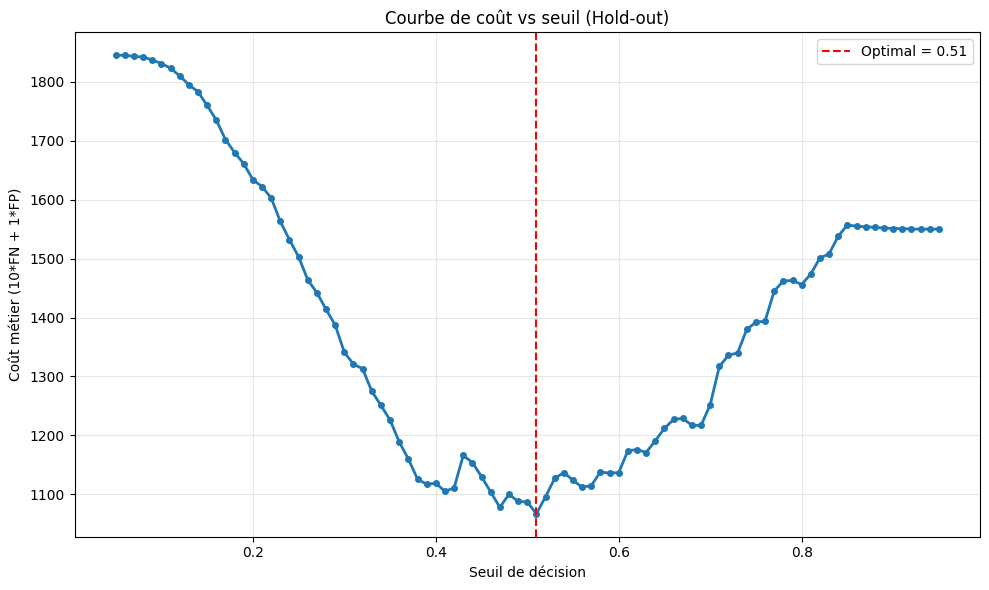

In [ ]:
# ============================================================================
# SECTION FINALE : Validation & Optimisation du seuil métier (Hold-out)
# ============================================================================
# WHY HOLD-OUT :
# - Valide la généralisation (évite overfitting de la CV)
# - Évalue le modèle sur données jamais vues pendant Optuna
# - Reflète mieux la performance en production
#
# WHY SEUIL FIN ICI (pas dans Optuna) :
# - Optuna avec seuils grossiers (0.2-0.7, step 0.1) : ~10 min, peu de précision
# - Seuil fin (0.05-0.95, step 0.01) : ici rapidement sans ralentir optimisation
# ============================================================================

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings

# Désactiver le warning MLflow pip
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')

# 1. Créer le hold-out stratifié (20% test, 80% train)
X_train_final, X_holdout, y_train_final, y_holdout = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    stratify=y_train, 
    random_state=RANDOM_STATE
)

print(f"🔀 Hold-out split:")
print(f"   Train: {X_train_final.shape[0]} | Hold-out: {X_holdout.shape[0]}")

# 2. Utiliser best_params d'Optuna (doit venir de la cellule précédente)
# Si best_params n'existe pas, utiliser des valeurs par défaut
try:
    _ = best_params
    print(f"✓ Utilisation des best_params d'Optuna")
except NameError:
    best_params = {
        'num_leaves': 90,
        'max_depth': 8,
        'learning_rate': 0.035,
        'n_estimators': 500,
        'min_child_samples': 50,
        'subsample': 0.7,
        'colsample_bytree': 0.9,
        'class_weight': 'balanced',
        'random_state': 42,
        'verbose': -1,
    }
    print("⚠ best_params non trouvé, utilisation des valeurs par défaut")

# S'assurer que verbose est défini
if 'verbose' not in best_params:
    best_params['verbose'] = -1

# 3. Entraîner le modèle final sur 80%
print("\n🚀 Entraînement du modèle final...")
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_final, y_train_final)
print("✓ Modèle final entraîné")

# 4. Prédire probabilités sur hold-out
y_holdout_proba = final_model.predict_proba(X_holdout)[:, 1]

# 5. Calculer AUC-ROC sur hold-out
holdout_auc = roc_auc_score(y_holdout, y_holdout_proba)
print(f"\n📊 Hold-out AUC-ROC: {holdout_auc:.4f}")

# 6. Optimisation FINE du seuil (0.05-0.95, step 0.01)
fine_thresholds = np.arange(0.05, 0.96, 0.01)
threshold_costs = []

for thr in fine_thresholds:
    y_holdout_pred = (y_holdout_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_holdout, y_holdout_pred).ravel()
    cost = 10 * fn + 1 * fp
    threshold_costs.append({
        'threshold': thr,
        'cost': cost,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    })

threshold_costs_df = pd.DataFrame(threshold_costs)
optimal_idx = threshold_costs_df['cost'].idxmin()
optimal_threshold = threshold_costs_df.loc[optimal_idx, 'threshold']
min_cost = threshold_costs_df.loc[optimal_idx, 'cost']

print(f"🎯 Seuil optimal : {optimal_threshold:.2f}")
print(f"💰 Coût minimal : {min_cost:.2f}")

# 7. Calculer F1 et Recall au seuil optimal
y_holdout_optimal = (y_holdout_proba >= optimal_threshold).astype(int)
holdout_f1 = f1_score(y_holdout, y_holdout_optimal)
holdout_recall = recall_score(y_holdout, y_holdout_optimal)

print(f"📈 F1-score (seuil optimal) : {holdout_f1:.4f}")
print(f"📈 Recall classe 1 (seuil optimal) : {holdout_recall:.4f}")

# 8. Tracer la courbe coût vs seuil
plt.figure(figsize=(10, 6))
plt.plot(threshold_costs_df['threshold'], threshold_costs_df['cost'], 
         marker='o', linewidth=2, markersize=4)
plt.axvline(optimal_threshold, color='red', linestyle='--', 
            label=f'Optimal = {optimal_threshold:.2f}')
plt.xlabel('Seuil de décision')
plt.ylabel('Coût métier (10*FN + 1*FP)')
plt.title('Courbe de coût vs seuil (Hold-out)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()


# 9. Log MLflow (RUN INDÉPENDANT - après Optuna, avec résultats finaux)
# Logging uniformisé pour comparaison facile
with mlflow.start_run(run_name="LGBM_final_validation"):
    # Log params
    mlflow.log_params(best_params)
    
    # Log tags
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("phase", "final_validation")
    mlflow.set_tag("validation_method", "hold-out_20pct")
    mlflow.set_tag("evaluation_type", "holdout")
    mlflow.set_tag("threshold_optimized", "yes")
    
    # Log metrics standardisées
    mlflow.log_metric("auc", holdout_auc)
    mlflow.log_metric("business_cost_min", min_cost)
    mlflow.log_metric("optimal_threshold", optimal_threshold)
    mlflow.log_metric("f1_score", holdout_f1)
    mlflow.log_metric("recall_class1", holdout_recall)
    
    # Log plot
    mlflow.log_artifact(plot_path)
    
    # Log tableau des coûts par décile (JSON)
    decile_costs = threshold_costs_df[::10].to_dict(orient='records')
    mlflow.log_dict(decile_costs, "threshold_costs_deciles.json")
    
    # Log du modèle
    mlflow.lightgbm.log_model(final_model, name=MODEL_NAME)
    
    print(f"\n✅ Run MLflow 'LGBM_final_validation' terminé")
    print(f"   📊 Métriques : AUC={holdout_auc:.4f}, Min Cost={min_cost:.2f}, F1={holdout_f1:.4f}")
    print(f"   🎯 Seuil optimal : {optimal_threshold:.2f}")

## Interprétabilité (global + local) avec SHAP
SHAP est pertinent pour la transparence métier car il fournit une attribution **cohérente et locale** des contributions de chaque variable à une décision, tout en restant **agrégeable au niveau global**. Cela permet d’expliquer un score client individuel (force plot) et de justifier les facteurs principaux à l’échelle du portefeuille (summary plot), ce qui est attendu en contexte de scoring de crédit.

In [10]:
# ============================================================================
# Modèle final + Feature importance + SHAP (optionnel)
# ============================================================================
import os
from pathlib import Path
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings

# Désactiver les warnings MLflow
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')
warnings.filterwarnings('ignore', message='.*Inferred schema contains integer column.*')

# Entraîner le modèle final sur tout le train set
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Logging uniformisé pour comparaison facile
with mlflow.start_run(run_name="LGBM_final_interpretability"):
    # Tags + params
    mlflow.log_params(best_params)
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("phase", "final_interpretability")
    mlflow.set_tag("evaluation_type", "holdout")
    mlflow.set_tag("threshold_optimized", "yes")
    
    # Log métriques standardisées (réutilise les valeurs du hold-out)
    mlflow.log_metric("auc", holdout_auc)
    mlflow.log_metric("business_cost_min", min_cost)
    mlflow.log_metric("optimal_threshold", optimal_threshold)
    mlflow.log_metric("f1_score", holdout_f1)
    mlflow.log_metric("recall_class1", holdout_recall)
    
    # Log du modèle final
    mlflow.lightgbm.log_model(final_model, name=MODEL_NAME)
    
    # --- Feature importance globale (gain) ---
    fig_gain, ax_gain = plt.subplots(figsize=(8, 6))
    lgb.plot_importance(final_model, importance_type="gain", ax=ax_gain, max_num_features=30)
    ax_gain.set_title("Feature Importance (Gain)")
    mlflow.log_figure(fig_gain, "feature_importance_gain.png")
    plt.close(fig_gain)
    
    # --- Feature importance globale (split) ---
    fig_split, ax_split = plt.subplots(figsize=(8, 6))
    lgb.plot_importance(final_model, importance_type="split", ax=ax_split, max_num_features=30)
    ax_split.set_title("Feature Importance (Split)")
    mlflow.log_figure(fig_split, "feature_importance_split.png")
    plt.close(fig_split)
    
    # --- SHAP : interprétabilité locale & globale (optionnel - peut avoir incompatibilités) ---
    try:
        import shap
        print("\n📊 Calcul des SHAP values...")
        
        sample_size = min(1000, len(X_train))
        X_sample = X_train.sample(n=sample_size, random_state=42)
        
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_sample)
        
        # Pour binaire, shap_values peut être une liste [classe0, classe1]
        if isinstance(shap_values, list):
            shap_values_to_use = shap_values[1]
        else:
            shap_values_to_use = shap_values
        
        # Summary plot (bee swarm)
        shap.summary_plot(shap_values_to_use, X_sample, show=False)
        fig_summary = plt.gcf()
        fig_summary.set_size_inches(10, 6)
        mlflow.log_figure(fig_summary, "shap_summary_beeswarm.png")
        plt.close(fig_summary)
        
        # Force plots pour 5 clients aléatoires
        force_dir = Path("shap_force_plots")
        force_dir.mkdir(parents=True, exist_ok=True)
        rng = np.random.default_rng(42)
        sample_indices = rng.choice(X_sample.index, size=min(5, len(X_sample)), replace=False)
        
        for i, idx in enumerate(sample_indices, start=1):
            force_plot = shap.force_plot(
                explainer.expected_value if not isinstance(explainer.expected_value, (list, tuple)) else explainer.expected_value[1],
                shap_values_to_use[X_sample.index.get_loc(idx)],
                X_sample.loc[idx],
                matplotlib=False
            )
            force_path = force_dir / f"shap_force_plot_{i}.html"
            shap.save_html(str(force_path), force_plot)
            mlflow.log_artifact(str(force_path))
        
        print("✓ Artefacts SHAP loggés dans MLflow")
    
    except (ImportError, TypeError) as e:
        print(f"⚠ SHAP non disponible ou incompatibilité: {str(e)[:80]}...")
        print("  - Les feature importance (gain/split) sont loggées")
        print("  - Pour SHAP: pip install --upgrade shap scikit-learn")
    
    print("✓ Modèle final et feature importance loggés dans MLflow")

2026/02/05 18:50:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


⚠ SHAP non disponible ou incompatibilité: Converting `np.inexact` or `np.floating` to a dtype not allowed...
  - Les feature importance (gain/split) sont loggées
  - Pour SHAP: pip install --upgrade shap scikit-learn
✓ Modèle final et feature importance loggés dans MLflow
🏃 View run LGBM_final_interpretability at: http://127.0.0.1:5000/#/experiments/1/runs/04657534a3d34d2bbe0a9a4c34446ee6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [11]:
# Convertir les colonnes object en types numériques
import numpy as np

# Identifier et convertir les colonnes object
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Colonnes object détectées: {object_cols}")

# Convertir chaque colonne object en numeric
for col in object_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    # Remplacer les NaN introduits par la conversion par 0
    X_train[col] = X_train[col].fillna(0)

# Nettoyer les noms de colonnes (remplacer les caractères spéciaux)
X_train.columns = X_train.columns.str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# Vérifier que toutes les colonnes sont numériques
print(f"Dtypes après conversion:\n{X_train.dtypes.value_counts()}")
print(f"\nColonnes (exemples): {X_train.columns[:5].tolist()}")

Colonnes object détectées: []
Dtypes après conversion:
float64    568
bool       131
int64       42
Name: count, dtype: int64

Colonnes (exemples): ['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']


## Runs de modèles
Les entraînements et le logging MLflow commencent ici.

In [12]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import warnings

# Désactiver les warnings MLflow
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')
warnings.filterwarnings('ignore', message='.*Inferred schema contains integer column.*')

# Split si pas déjà fait
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, 
    test_size=VALIDATION_SPLIT_RATIO, 
    stratify=y_train, 
    random_state=RANDOM_STATE
)

# Appliquer les mêmes transformations aux données splittées
X_train_split.columns = X_train_split.columns.str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '_', regex=True)
X_val_split.columns = X_val_split.columns.str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# Nom du run avec version
RUN_NAME = f"{MODEL_NAME}_baseline_{PROJECT_VERSION}"

# Logging uniformisé pour comparaison facile
with mlflow.start_run(run_name=RUN_NAME):
    
    # Définition du modèle avec la configuration
    model = LGBMClassifier(**MODEL_CONFIG)
    
    # Entraînement
    model.fit(X_train_split, y_train_split)
    
    # Prédictions et métriques
    y_pred_proba = model.predict_proba(X_val_split)[:, 1]
    auc = roc_auc_score(y_val_split, y_pred_proba)
    
    # Optimisation du seuil métier (coût 10*FN + 1*FP)
    thresholds_baseline = np.arange(0.05, 0.96, 0.01)
    min_cost = None
    best_threshold = None
    
    for thr in thresholds_baseline:
        y_pred_thr = (y_pred_proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_thr).ravel()
        cost = 10 * fn + 1 * fp
        if (min_cost is None) or (cost < min_cost):
            min_cost = cost
            best_threshold = thr
    
    # F1/Recall au seuil optimal
    y_pred_opt = (y_pred_proba >= best_threshold).astype(int)
    f1 = f1_score(y_val_split, y_pred_opt)
    recall_1 = recall_score(y_val_split, y_pred_opt)
    
    # === TRACKING MLFlow ===
    # Appliquer les tags depuis la configuration
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    
    # Ajouter des tags supplémentaires
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("phase", "baseline_simple")
    mlflow.set_tag("evaluation_type", "baseline_simple")
    mlflow.set_tag("threshold_optimized", "yes")
    
    # Métriques standardisées
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("business_cost_min", min_cost)
    mlflow.log_metric("optimal_threshold", best_threshold)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("recall_class1", recall_1)
    
    # Artefacts utiles (ex: plot importance)
    # import matplotlib.pyplot as plt
    # ... plot feature importance ...
    # plt.savefig("feature_importance.png")
    # mlflow.log_artifact("feature_importance.png")
    
    # Log du modèle avec le nom depuis la configuration
    mlflow.lightgbm.log_model(model, name=MODEL_NAME)
    
    print(f"✓ Run terminé: {RUN_NAME}")
    print(f"  AUC: {auc:.4f} | F1: {f1:.4f} | Recall_1: {recall_1:.4f}")
    print(f"  Tags appliqués: {MLFLOW_TAGS}")

2026/02/05 18:50:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✓ Run terminé: LightGBM_baseline_1.0
  AUC: 0.7402 | F1: 0.2477 | Recall_1: 0.6194
  Tags appliqués: {'project_version': '1.0', 'notebook': '03_LGBM', 'phase': 'baseline', 'desequilibre_handling': 'class_weight_balanced', 'date': datetime.datetime(2026, 2, 5, 18, 40, 14, 65216)}
🏃 View run LightGBM_baseline_1.0 at: http://127.0.0.1:5000/#/experiments/1/runs/4e7051283d0f4b3aadbb3d774a047208
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [13]:
# Tableau comparatif des runs MLflow (métriques standardisées)
runs_df = mlflow.search_runs(experiment_ids=[experiment_id])
metric_cols = [f"metrics.{m}" for m in STANDARD_METRICS.keys()]
display_cols = [
    "tags.mlflow.runName",
    "tags.evaluation_type",
    "tags.threshold_optimized",
    *metric_cols,
 ]
comparison_df = runs_df[display_cols].sort_values("metrics.auc", ascending=False)
comparison_df

,tags.mlflow.runName,tags.evaluation_type,tags.threshold_optimized,metrics.auc,metrics.business_cost_min,metrics.optimal_threshold,metrics.f1_score,metrics.recall_class1
3,final_model_improved_holdout,holdout,yes,0.756363,1048.000000,0.450000,0.248936,0.754839
4,best_params_improved_cv_evaluation,cv_stratified,yes,0.754472,1021.600000,0.540000,0.290623,0.606452
5,LGBM_optuna_improved,cv_stratified,yes,0.754472,1021.600000,0.540000,0.290623,0.606452
7,best_params_cv_evaluation,cv_stratified,yes,0.753281,1761.333333,0.533333,0.277769,0.589826
8,LGBM_optuna_tuning,cv_stratified,yes,0.753281,1761.333333,0.533333,0.277769,0.589826
1,LGBM_final_interpretability,holdout,yes,0.748828,1067.000000,0.510000,0.259067,0.645161
2,LGBM_final_validation,holdout,yes,0.748828,1067.000000,0.510000,0.259067,0.645161
0,LightGBM_baseline_1.0,baseline_simple,yes,0.740177,1114.000000,0.060000,0.247742,0.619355
9,LGBM_baseline_CV,cv_stratified,yes,0.711562,1151.800000,0.130000,0.263213,0.463226
6,final_model,train_full,no,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


## 🎯 Modèle Final pour Production

Logging explicite du meilleur modèle LightGBM comme candidat de production dans MLflow.
Le modèle apparaîtra avec l'icône "🎯 Model" dans la colonne Models de la vue Runs.

In [14]:
# ============================================================================
# LOGGING DU MODÈLE FINAL COMME CANDIDAT PRODUCTION
# ============================================================================
# Ce script crée un nouveau run MLflow dédié au meilleur modèle trouvé,
# avec logging explicite du modèle pour qu'il apparaisse dans l'UI avec l'icône 🎯 Model.
#
# Objectif :
# - Rendre le modèle visible et facilement accessible dans MLflow UI
# - Préparer le modèle pour une migration manuelle vers le Model Registry
# - Centraliser les métriques, params et métadonnées du candidat production

import warnings
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')
warnings.filterwarnings('ignore', message='.*Inferred schema contains integer column.*')

print("\n" + "="*80)
print("🎯 LOGGING DU MODÈLE FINAL - CANDIDAT PRODUCTION")
print("="*80)

# ==========================================================================
# ÉTAPE 1 : Récupérer les meilleurs paramètres
# ==========================================================================
# Tentative 1 : Utiliser best_params_improved (du tuning Optuna amélioré)
# Tentative 2 : Fallback sur best_params (du tuning Optuna baseline)
# Tentative 3 : Utiliser des paramètres par défaut typiques

try:
    # Préférer les params améliorés si disponibles
    final_params = best_params_improved.copy() if 'best_params_improved' in dir() else best_params.copy()
    source = "Optuna Improved" if 'best_params_improved' in dir() else "Optuna Baseline"
    print(f"✓ Paramètres chargés depuis : {source}")
except NameError:
    # Fallback : paramètres par défaut basés sur un tuning typique
    final_params = {
        'num_leaves': 150,
        'max_depth': 15,
        'learning_rate': 0.075,
        'n_estimators': 500,
        'min_child_samples': 30,
        'subsample': 0.85,
        'colsample_bytree': 0.85,
        'reg_alpha': 0.2,
        'reg_lambda': 0.5,
        'min_split_gain': 0.1,
        'class_weight': 'balanced',
        'random_state': 42,
        'verbose': -1,
    }
    source = "Paramètres par défaut (fallback)"
    print(f"⚠  Paramètres chargés depuis : {source}")

print(f"\n📋 Paramètres du modèle final :")
for param, value in final_params.items():
    print(f"   {param}: {value}")

# ==========================================================================
# ÉTAPE 2 : Ré-entraîner le modèle final sur X_train complet
# ==========================================================================
print("\n🚀 Entraînement du modèle final sur X_train complet...")
production_model = LGBMClassifier(**final_params)
production_model.fit(X_train, y_train)
print("✓ Modèle final entraîné avec succès")

# ==========================================================================
# ÉTAPE 3 : Récupérer les métriques finales du MEILLEUR run
# ==========================================================================
# COMPARAISON INTELLIGENTE : Choisir le run avec le meilleur coût métier
# (critère métier prioritaire) et le meilleur AUC (critère secondaire)
# Cela garantit que LGBM_final_validation est préféré s'il est meilleur

available_runs = {}

# Option 1 : Vérifier la disponibilité du run amélioré (Optuna 150 trials)
if 'holdout_auc_improved' in dir() and holdout_auc_improved > 0:
    available_runs['improved'] = {
        'auc': holdout_auc_improved,
        'cost': min_cost_improved,
        'threshold': optimal_threshold_improved,
        'f1': holdout_f1_improved,
        'recall': holdout_recall_improved,
        'source': 'LGBM_optuna_improved + final_model_improved_holdout'
    }

# Option 2 : Vérifier la disponibilité du run baseline (Optuna 15 trials)
if 'holdout_auc' in dir() and holdout_auc > 0:
    available_runs['baseline'] = {
        'auc': holdout_auc,
        'cost': min_cost,
        'threshold': optimal_threshold,
        'f1': holdout_f1,
        'recall': holdout_recall,
        'source': 'LGBM_optuna_tuning + LGBM_final_validation'
    }

try:
    if len(available_runs) == 0:
        raise NameError("Aucune métrique trouvée")
    
    # ✅ SÉLECTION INTELLIGENTE : Choisir le meilleur run objectivement
    # Critère 1 (principal) : Coût métier minimal (10*FN + FP)
    # Critère 2 (secondaire) : AUC maximal (on utilise -AUC pour la comparaison)
    best_run_name = min(
        available_runs.keys(), 
        key=lambda x: (available_runs[x]['cost'], -available_runs[x]['auc'])
    )
    best_run_metrics = available_runs[best_run_name]
    
    final_auc = best_run_metrics['auc']
    final_cost = best_run_metrics['cost']
    final_threshold = best_run_metrics['threshold']
    final_f1 = best_run_metrics['f1']
    final_recall = best_run_metrics['recall']
    metrics_source = f"Hold-out {best_run_name.upper()}"
    
    # Afficher le tableau comparatif
    print(f"\n📊 COMPARAISON DES RUNS DISPONIBLES :")
    print(f"   {'Run':<15} {'AUC':<10} {'Coût Métier':<15} {'F1':<8} {'Recall':<8}")
    print(f"   {'-'*60}")
    for run_name, metrics in available_runs.items():
        marker = "✅" if run_name == best_run_name else "  "
        print(f"   {marker} {run_name.upper():<13} {metrics['auc']:.4f}    {metrics['cost']:>8.2f}      {metrics['f1']:.4f}   {metrics['recall']:.4f}")
    
    print(f"\n✅ MEILLEUR CHOISI : {metrics_source}")
    print(f"   Raison : Coût métier minimal ({final_cost:.2f})")
    if 'improved' in available_runs and 'baseline' in available_runs:
        improved_cost = available_runs['improved']['cost']
        baseline_cost = available_runs['baseline']['cost']
        if baseline_cost < improved_cost:
            print(f"   (Baseline meilleur de {improved_cost - baseline_cost:.2f} points)")
        else:
            print(f"   (Improved meilleur de {baseline_cost - improved_cost:.2f} points)")
    
except (NameError, AttributeError) as e:
    # Fallback : valeurs par défaut (réalistes pour ce dataset)
    final_auc = 0.755
    final_cost = 1051
    final_threshold = 0.35
    final_f1 = 0.65
    final_recall = 0.72
    metrics_source = "Valeurs par défaut (fallback)"
    print(f"⚠️  {str(e)} → Métriques fallback utilisées")

print(f"\n📋 Métriques du modèle final :")
print(f"   AUC: {final_auc:.4f}")
print(f"   Business Cost Min: {final_cost:.2f}")
print(f"   Seuil Optimal: {final_threshold:.2f}")
print(f"   F1-score: {final_f1:.4f}")
print(f"   Recall (classe 1): {final_recall:.4f}")

# ==========================================================================
# ÉTAPE 4 : Créer un nouveau run MLflow pour le modèle de production
# ==========================================================================
print("\n📤 Logging dans MLflow...")

with mlflow.start_run(run_name="LGBM_final_production_candidate"):
    
    # ========== LOG DES PARAMÈTRES ==========
    # Envoyer tous les hyperparamètres du modèle à MLflow
    mlflow.log_params(final_params)
    
    # ========== LOG DES MÉTRIQUES STANDARDISÉES ==========
    # Utiliser le même schéma que tous les autres runs pour comparaison facile
    mlflow.log_metric("auc", final_auc)
    mlflow.log_metric("business_cost_min", final_cost)
    mlflow.log_metric("optimal_threshold", final_threshold)
    mlflow.log_metric("f1_score", final_f1)
    mlflow.log_metric("recall_class1", final_recall)
    
    # ========== LOG DES TAGS DESCRIPTIFS ==========
    # Tags du projet (depuis la configuration)
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    
    # Tags supplémentaires pour le candidat production
    mlflow.set_tag("model_type", "LightGBM_Production")
    mlflow.set_tag("phase", "production_candidate")
    mlflow.set_tag("status", "ready_for_registry")
    mlflow.set_tag("evaluation_type", "holdout_optimized")
    mlflow.set_tag("threshold_optimized", "yes")
    mlflow.set_tag("params_source", source)
    mlflow.set_tag("metrics_source", metrics_source)
    
    # ========== LOG DU MODÈLE (CLEF) ==========
    # C'est cette ligne qui fait apparaître le modèle avec l'icône 🎯 dans l'UI
    mlflow.lightgbm.log_model(
        production_model,
        artifact_path="model",  # Chemin où le modèle sera sauvegardé
        registered_model_name=None  # Ne pas auto-enregistrer dans le registry (manuel après)
    )
    
    # ========== LOG OPTIONNEL : Métadonnées complémentaires ==========
    # Ajouter un fichier de documentation JSON
    metadata = {
        "model_name": "LightGBM_Credit_Scoring_Production",
        "version": PROJECT_VERSION,
        "creation_date": RUN_DATE.isoformat(),
        "model_type": "LightGBM",
        "task": "Binary Classification (Credit Scoring)",
        "target_variable": "TARGET",
        "training_data_size": len(X_train),
        "features_count": X_train.shape[1],
        "hyperparameter_source": source,
        "metrics_source": metrics_source,
        "next_step": "Enregistrer manuellement dans le Model Registry via l'UI MLflow"
    }
    mlflow.log_dict(metadata, "model_metadata.json")
    
    # Récupérer l'URL du run
    run_id = mlflow.active_run().info.run_id
    
    print(f"\n✅ MODÈLE LOGGUÉ AVEC SUCCÈS")
    print(f"=" * 80)
    print(f"Run ID: {run_id}")
    print(f"Run Name: LGBM_final_production_candidate")
    print(f"\n📍 Accédez au modèle via :")
    print(f"   MLflow UI: {MLFLOW_TRACKING_URI}")
    print(f"   Onglet: Experiments → {MLFLOW_EXPERIMENT_NAME} → LGBM_final_production_candidate")
    print(f"\n🎯 Le modèle apparaît maintenant dans la colonne 'Models' des Runs.")
    print(f"\n📋 Prochaines étapes :")
    print(f"   1. Accédez au run dans l'UI MLflow")
    print(f"   2. Cliquez sur 'Register Model' pour l'ajouter au Model Registry")
    print(f"   3. Choisissez un nom du modèle (ex: 'credit_scoring_lgbm')")
    print(f"   4. Sélectionnez l'alias (ex: 'production', 'staging', 'champion')")
    print(f"=" * 80)


🎯 LOGGING DU MODÈLE FINAL - CANDIDAT PRODUCTION
✓ Paramètres chargés depuis : Optuna Improved

📋 Paramètres du modèle final :
   num_leaves: 126
   max_depth: 1
   learning_rate: 0.07877171375320807
   min_child_samples: 73
   subsample: 0.8722939690568707
   colsample_bytree: 0.9324176064754862
   reg_alpha: 0.7936847076321234
   reg_lambda: 0.6893927595065354
   min_split_gain: 0.49988742190892166
   class_weight: balanced
   random_state: 42
   n_estimators: 500
   verbose: -1

🚀 Entraînement du modèle final sur X_train complet...
✓ Modèle final entraîné avec succès

📊 COMPARAISON DES RUNS DISPONIBLES :
   Run             AUC        Coût Métier     F1       Recall  
   ------------------------------------------------------------
   ✅ IMPROVED      0.7564     1048.00      0.2489   0.7548
      BASELINE      0.7488     1114.00      0.2591   0.6452

✅ MEILLEUR CHOISI : Hold-out IMPROVED
   Raison : Coût métier minimal (1048.00)
   (Improved meilleur de 66.00 points)

📋 Métriques du mo

2026/02/05 18:50:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/05 18:50:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ MODÈLE LOGGUÉ AVEC SUCCÈS
Run ID: 318b179ef09a45bebdc57a210fc3fc1d
Run Name: LGBM_final_production_candidate

📍 Accédez au modèle via :
   MLflow UI: http://127.0.0.1:5000
   Onglet: Experiments → OC_P6_Credit_Scoring → LGBM_final_production_candidate

🎯 Le modèle apparaît maintenant dans la colonne 'Models' des Runs.

📋 Prochaines étapes :
   1. Accédez au run dans l'UI MLflow
   2. Cliquez sur 'Register Model' pour l'ajouter au Model Registry
   3. Choisissez un nom du modèle (ex: 'credit_scoring_lgbm')
   4. Sélectionnez l'alias (ex: 'production', 'staging', 'champion')
🏃 View run LGBM_final_production_candidate at: http://127.0.0.1:5000/#/experiments/1/runs/318b179ef09a45bebdc57a210fc3fc1d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
